## Bachelor Thesis - Informatik

### Variante 3 :
### Multiclass-Klassifizierung mit 1D Convolutional Neuronal Network

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Beschreibung der zugrunde liegenden Daten :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">



##### ▶️ Installation notwendiger Python-Bibliotheken

In [297]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install -U seaborn-image
#%pip install matplotlib.pyplot
#%pip install scikit-learn

##### ▶️ Importieren notwendiger Python-Bibliotheken

In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
****

In [3]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene/P1L' + label + '.csv', sep=',', header=None))    
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene/P2L' + label + '.csv', sep=',', header=None))    
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene/P3L' + label + '.csv', sep=',', header=None))    
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene/P4L' + label + '.csv', sep=',', header=None))    
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Unterlisten in jeweils ein Dataframe         #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([proband1, proband2, proband3])

##############################################################
# Daten von Proband 4 zum validieren --> getrennt vom Rest   #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)

##### ▶️ Umwandlung der Daten in geeignete Formate

In [4]:
##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
labels = all_data[all_data.columns[-1]]

##############################################################
# Stichprobe aus Daten von Proband 4 ziehen                  #
# Datentyp Pandas Dataframe                                  #
##############################################################
proband4 = proband4.sample(n=20, random_state=100)

##############################################################
# Dann erst Labels auslesen, damit Zuordnung erhalten bleibt #
# Datentyp Pandas Dataframe                                  #
##############################################################
validation_labels = proband4[proband4.columns[-1]]


##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
classes = np.unique(labels)
validation_classes = np.unique(validation_labels)
print("Classes Shape:",classes.shape)
print("Validation Classes Shape:",validation_classes.shape)


##############################################################
# Features der Gesten auslesen                               #
# Datentyp Pandas Dataframe                                  #
##############################################################
features = all_data.drop(64, axis=1).copy()
validation = proband4.drop(64, axis=1).copy()


##############################################################
# Konvertiere die Listen in Numpy-Arrays                     #
# Datentyp Numpy-Array                                       #
##############################################################
features = np.array(features)
features = features.reshape(-1,64)

validation = np.array(validation)
validation = validation.reshape(-1,64)


labels = np.array(labels).astype('int')
validation_labels = np.array(validation_labels).astype('int')


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Features Shape: ", features.shape)
print("Validation Shape: ", validation.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Labels Shape:", labels.shape)
print("Validation Labels Shape:", validation_labels.shape)

print("Labels:", labels.ndim)
print("Validation Labels:", validation_labels.ndim)


Classes Shape: (4,)
Validation Classes Shape: (4,)
Features Shape:  (4548, 64)
Validation Shape:  (20, 64)
Labels Shape: (4548,)
Validation Labels Shape: (20,)
Labels: 1
Validation Labels: 1


#### ▶️ Normalisierung der Daten

In [5]:

##############################################################
# Datenskalierung mit Z-Score                                #
##############################################################  
sc = StandardScaler()


##############################################################
# Normalisierung durchführen                                 #
# Datentyp Numpy Array                                       #
##############################################################  
features = sc.fit_transform(features)
features

validation = sc.fit_transform(validation)
validation


array([[ 0.80812746,  2.27399769,  1.39690651, ..., -0.39697298,
        -0.15607862,  2.05182939],
       [ 0.18649095,  0.98869465, -1.37798679, ...,  0.04410811,
        -0.23411793,  1.88048665],
       [-2.71447941, -0.09886946, -0.05360589, ...,  0.26464865,
         0.07803931, -0.51831181],
       ...,
       [-1.26399423,  0.19773893,  1.08157773, ...,  0.4851892 ,
         0.07803931, -0.26129769],
       [-0.84956989, -0.59321679, -1.9455786 , ...,  0.70572975,
         1.40470759, -0.43264044],
       [ 2.05140047, -1.08756411,  0.19865713, ...,  0.26464865,
         0.31215724,  0.25273055]])

### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [7]:
##############################################################
# Anzahl der Klassen, bzw. der Gesten                        #
# Fixwert 4                                                  #
##############################################################
num_classes = 4


##############################################################
# 64 x 1 Matrix --> 1D Arrays für CNN-Modell                 #
##############################################################
input_shape = (64, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = 100) # type: ignore


##############################################################
# Konvertieren nach Float                                    #
##############################################################
X_train = X_train.astype("float32")
X_test = X_test.astype("float32") 
X_validate = validation.astype('float32')


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("X_train Vectorform:", X_train.shape)
print("X_test Vectorform:", X_test.shape)
print("X_validate Vectorform:", X_validate.shape)
print("y_train Vectorform:", y_train.shape)
print("y_test Vectorform:", y_test.shape)
print("y_validate Vectorform:", validation_labels.shape)
print()
print(features.shape[0], "Gesamtwerte")
print(X_train.shape[0], "Trainingswerte")
print(X_test.shape[0], "Testwerte")
print(X_validate.shape[0], "Validierungswerte")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
validation_labels = keras.utils.to_categorical(validation_labels, num_classes)

X_train Vectorform: (3183, 64)
X_test Vectorform: (1365, 64)
X_validate Vectorform: (20, 64)
y_train Vectorform: (3183,)
y_test Vectorform: (1365,)
y_validate Vectorform: (20, 4)

4548 Gesamtwerte
3183 Trainingswerte
1365 Testwerte
20 Validierungswerte


#### ▶️ Modellarchitektur<br>

In [45]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 32
epochs = 12

initializer='glorot_uniform'


##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Conv1D(64, 1, input_shape=input_shape, kernel_initializer=initializer))
model.add(layers.Activation('elu'))

model.add(layers.Conv1D(64, 2))
model.add(layers.Activation('elu'))

model.add(layers.Flatten())

model.add(layers.Dense(64))
model.add(layers.Activation('elu'))

model.add(layers.Dense(num_classes, activation = 'softmax'))

# Modellparameter ausgeben
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 64, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 63, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │       258,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,756 (1.02 MB)

 Trainable params: 266,756 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    #validation_data=(X_validate, validation_labels),
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
        #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')
    ]
)

Epoch 1/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4402 - loss: 1.2445 - val_accuracy: 0.7159 - val_loss: 0.6522 - learning_rate: 0.0010
Epoch 2/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7574 - loss: 0.6056 - val_accuracy: 0.7692 - val_loss: 0.5104 - learning_rate: 0.0010
Epoch 3/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8032 - loss: 0.4763 - val_accuracy: 0.8210 - val_loss: 0.4685 - learning_rate: 0.0010
Epoch 4/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8194 - loss: 0.4185 - val_accuracy: 0.8273 - val_loss: 0.4057 - learning_rate: 0.0010
Epoch 5/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8573 - loss: 0.3592 - val_accuracy: 0.8556 - val_loss: 0.3729 - learning_rate: 0.0010
Epoch 6/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8890 - loss: 0.3088 - val_accuracy: 0.8681 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 7/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9127 - loss: 0.2359 - val_accuracy: 

### ▶️ Ausgabe der Funktionen für Verlust und Genauigkeit

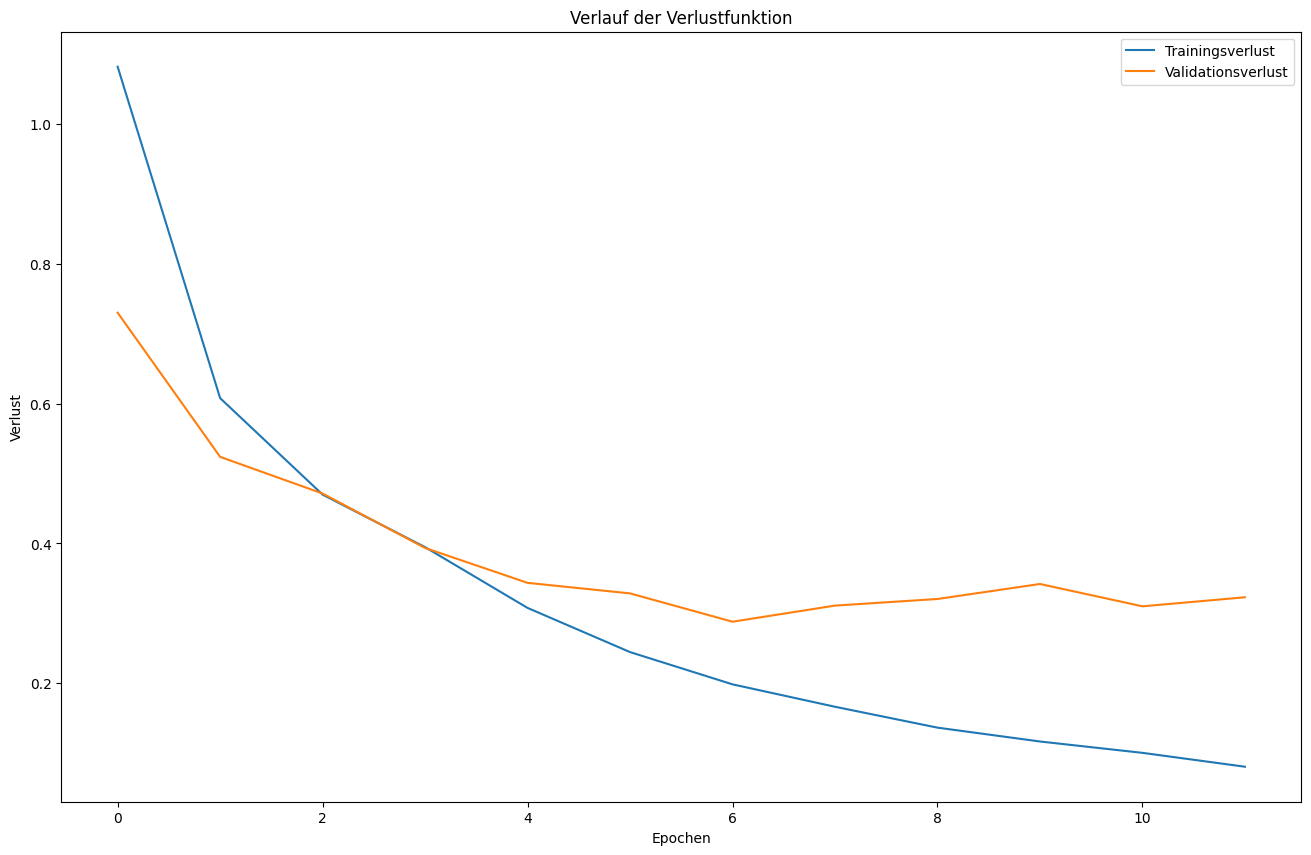

In [37]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

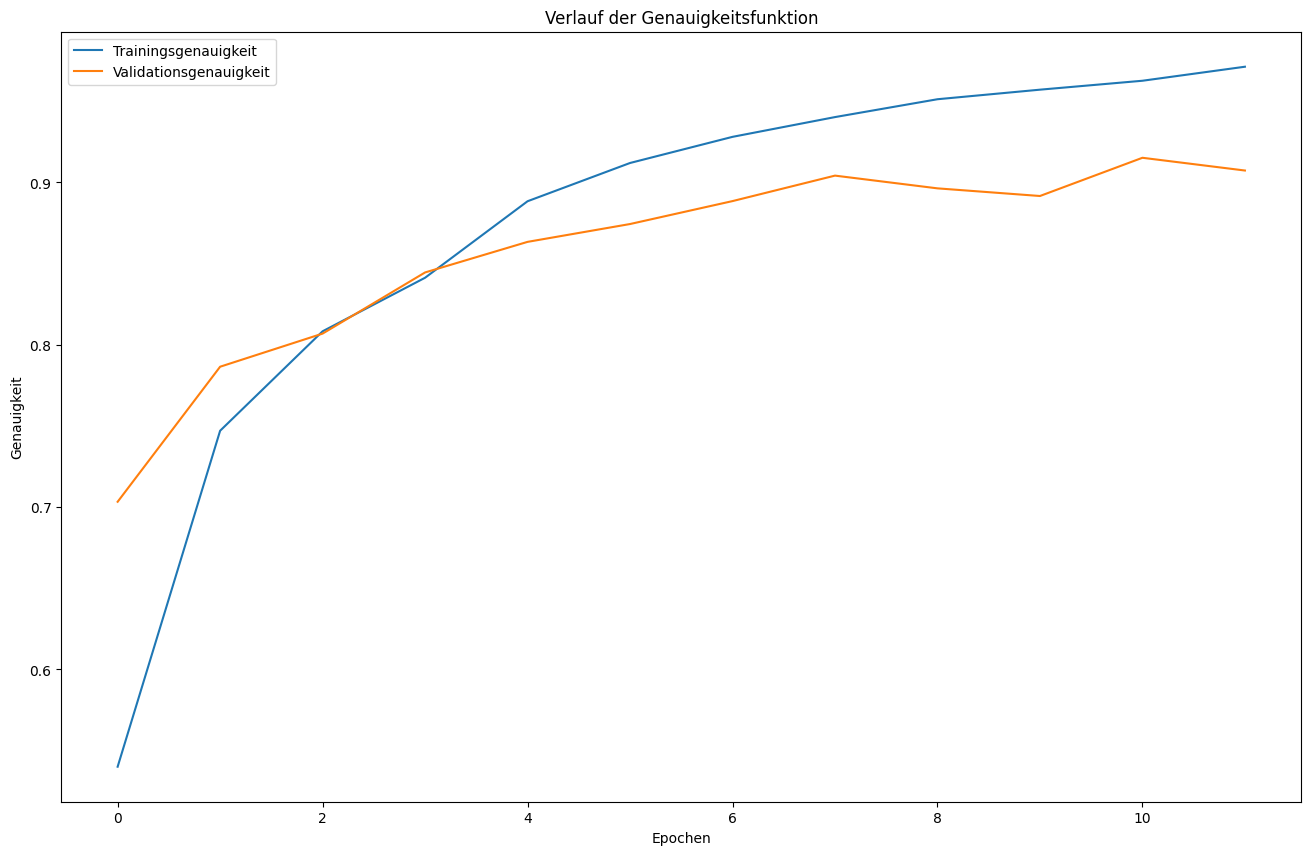

In [38]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Scores zur Beurteilung der Modellqualität 

In [39]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Testverlust :", score[0])
print("Testgenauigkeit :", score[1])

Testverlust : 0.29855719208717346
Testgenauigkeit : 0.9069597125053406


In [40]:
y = model.predict(np.array(features))[50]
#print(X[3212])
print("Es handelt sich um Geste : " + str(np.argmax(y)))

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Es handelt sich um Geste : 0


### ▶️ Metriken zur Beurteilung der Modellqualität 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


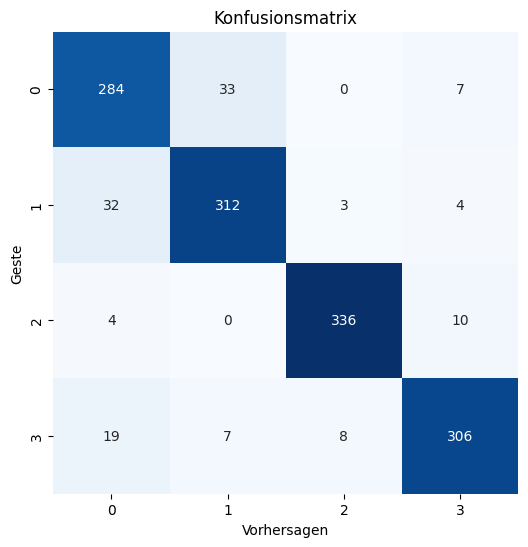

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       324
           1       0.89      0.89      0.89       351
           2       0.97      0.96      0.96       350
           3       0.94      0.90      0.92       340

    accuracy                           0.91      1365
   macro avg       0.91      0.91      0.91      1365
weighted avg       0.91      0.91      0.91      1365



In [41]:
#y_test_arg=np.argmax(validation_labels,axis=1)
y_test_arg=np.argmax(y_test,axis=1)
#y_pred = np.argmax(model.predict(validation),axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
# 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))